In [1]:
!nvidia-smi

Tue Jul 23 14:10:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Street View House Numbers Classification

We'll be using [Keras](https://keras.io/) to build a CNN to classify these images.

In [0]:
# let's just choose to import all we need at the start
# this keeps the code below neater

import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import sklearn.model_selection

## Loading Data

In [0]:
# Use Python to download the dataset
# (also on Kaggle at https://www.kaggle.com/victorythang113/street-view-house-number)

train_mat = keras.utils.get_file("train_32x32.mat", "https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/train_32x32.mat")
test_mat = keras.utils.get_file("test_32x32.mat", "https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/test_32x32.mat")

print("Train set present at", train_mat)
print("Test set present at", test_mat)

64282624/64275384 [==============================] - 6s 0us/step
Train set present at /root/.keras/datasets/train_32x32.mat
Test set present at /root/.keras/datasets/test_32x32.mat


We can load a MatLab file (`.mat`) with `scipy.io.loadmat()`

In [0]:
train_array = scipy.io.loadmat(train_mat)
print("Imported object is a", type(train_array))
print(train_array.keys())

print("Train set has the following shape:")
train_array["X"].shape, train_array["y"].shape

Imported object is a <class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Train set has the following shape:


((32, 32, 3, 73257), (73257, 1))

From the shape `(32, 32, 3, 73257), (73257, 1))`,  we can infer that:

*   The images are **32** pixels in width and height
*   These are RGB images (**3** colour channels)
*   There are **73257** training images in the set "X"
*   There are **73257** labels in the set "Y"

Let's display a grid of random images

In [0]:
num_images = train_array["X"].shape[-1]

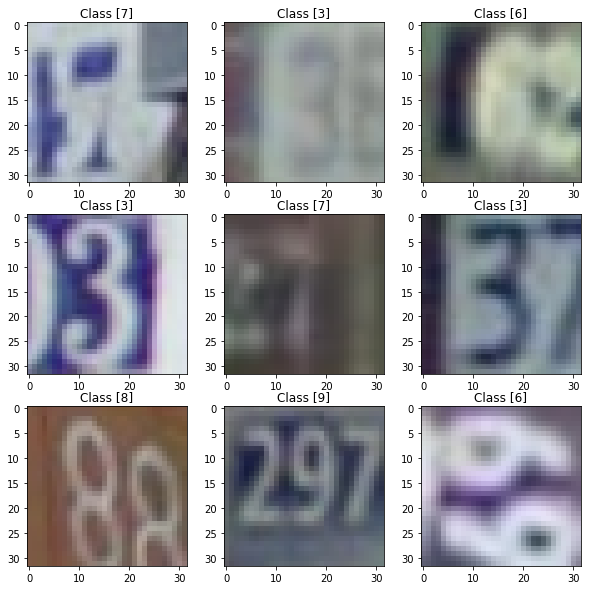

In [0]:
plt.figure(1, figsize=(10,10))

for i in range(9):
    n = random.randint(0, num_images-1) # pick a random image
    plt.subplot(3,3,i+1)
    image = train_array["X"][:,:,:,n].reshape((32,32,3))
    plt.imshow(image)
    plt.title("Class {}".format(train_array["y"][n]))
    
plt.show()

In [0]:
# we need to reshape the imported data to use it with Keras

list_labels = train_array["y"].reshape((num_images))
list_images = []

for i in range(num_images):
    image = train_array["X"][:,:,:,i].reshape((32,32,3))
    list_images.append(image)
    
list_labels = np.asarray(list_labels, dtype='int32')
list_images = np.asarray(list_images)

list_images.shape

(73257, 32, 32, 3)

In [0]:
classes = list(set(list_labels))
num_classes = len(classes)
print(num_classes, "unique classes:", classes)

10 unique classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Create our train-validation split

In [0]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(list_images, list_labels, test_size=0.2)

Pick one random image to show, just to verify that we've loaded the image correctly

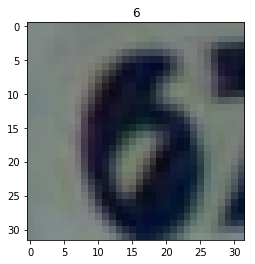

In [0]:
plt.figure(2)
n = random.randint(0, len(y_train))
plt.imshow(X_train[n])
plt.title(y_train[n])
plt.show()

One-hot encode target column [Keras Utils Documentation](https://keras.io/utils/)

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)

y_train.shape (58605, 11)
y_val.shape (14652, 11)


In [0]:
# what is one-hot encoding?

to_categorical(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

# Build a CNN in Keras

See also:

*   [Convolutional filters in Keras](https://keras.io/layers/convolutional/)
*   [Functional API](https://keras.io/getting-started/functional-api-guide/) (allows you to build more complex models)


In [0]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(11, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


*   [Keras Optimizers](https://keras.io/optimizers/)
*   [Keras Loss Functions](https://keras.io/losses/)

In [0]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
__________

Using TensorFlow backend.


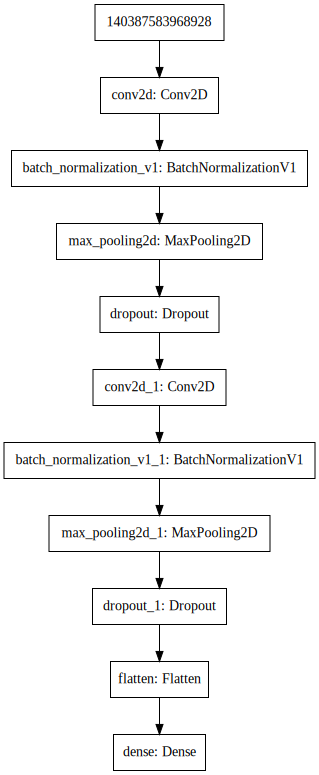

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train the model

*   [Training Callbacks](https://keras.io/callbacks/)


In [0]:
print("Training Progress:")
model_log = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=[X_val, y_val])

Training Progress:
Train on 58605 samples, validate on 14652 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
58605/58605 [==============================] - 10s 162us/sample - loss: 1.1896 - acc: 0.6577 - val_loss: 0.9137 - val_acc: 0.7520
Epoch 2/10
58605/58605 [==============================] - 6s 97us/sample - loss: 0.6318 - acc: 0.8196 - val_loss: 0.6747 - val_acc: 0.8150
Epoch 3/10
58605/58605 [==============================] - 6s 100us/sample - loss: 0.5401 - acc: 0.8451 - val_loss: 0.5798 - val_acc: 0.8370
Epoch 4/10
58605/58605 [==============================] - 6s 97us/sample - loss: 0.4919 - acc: 0.8584 - val_loss: 0.5399 - val_acc: 0.8507
Epoch 5/10
58605/58605 [==============================] - 6s 97us/sample - loss: 0.4607 - acc: 0.8673 - val_loss: 0.5113 - val_acc: 0.8541
Epoch 6/10
58605/58605 [==============================] - 6s 97us/sample - loss: 0.4374 - acc: 0.8736 - val_loss: 0.5519 - val_acc: 0.8434
Epoch 7/10
58605/58605 [======================

Look at the training history

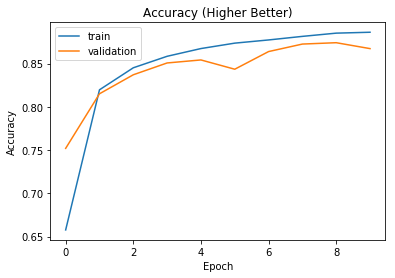

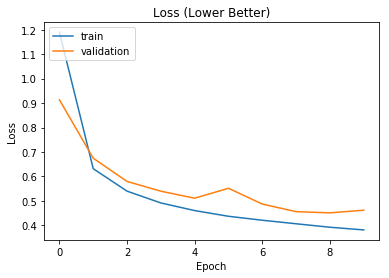

In [0]:
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Save the model!

In [0]:
model.save("model.h5")

## Evaluation (Validation Set)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

y_val_index = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(X_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(y_val_index, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

           1       0.81      0.95      0.88      2854
           2       0.93      0.90      0.91      2145
           3       0.87      0.80      0.84      1721
           4       0.91      0.89      0.90      1485
           5       0.79      0.91      0.85      1348
           6       0.87      0.82      0.85      1159
           7       0.93      0.79      0.85      1116
           8       0.89      0.75      0.81       993
           9       0.88      0.83      0.85       905
          10       0.89      0.89      0.89       926

   micro avg       0.87      0.87      0.87     14652
   macro avg       0.88      0.85      0.86     14652
weighted avg       0.87      0.87      0.87     14652



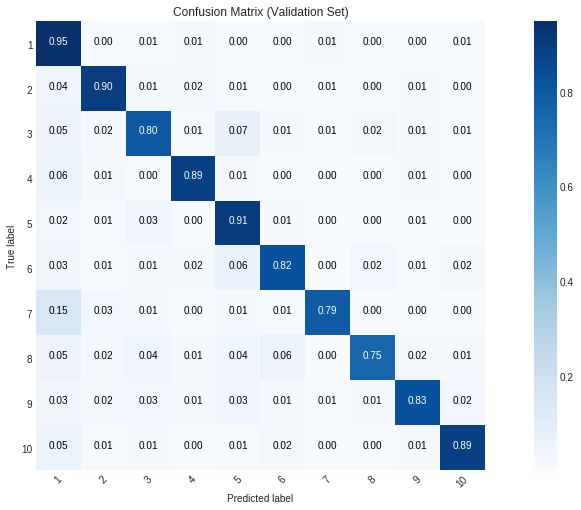

In [0]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(y_val_index, y_pred_class)
cnf_matrix = confusion_matrix(y_val_index, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)

# Running on the Test Set

In [0]:
# load Keras model from file

from tensorflow.keras.models import load_model

model = load_model("model.h5")

classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

In [0]:
from sklearn.metrics import accuracy_score

test_array = scipy.io.loadmat(test_mat)
print(test_array.keys())

print("Test set has the following shape:")
test_array["X"].shape, test_array["y"].shape

num_images = test_array["y"].shape[0]

test_labels = test_array["y"].reshape((num_images))
test_images = []

for i in range(num_images):
    image = test_array["X"][:,:,:,i].reshape((32,32,3))
    test_images.append(image)
    
test_labels = np.asarray(test_labels, dtype='int32')
test_images = np.asarray(test_images)

print("test_images:", test_images.shape)

test_labels = to_categorical(test_labels)

test_labels_index = np.argmax(test_labels, axis=1)
test_preds = model.predict(test_images)
test_preds_class = np.argmax(test_preds,axis=1)
print("Test set accuracy score:", accuracy_score(test_labels_index, test_preds_class))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Test set has the following shape:
test_images: (26032, 32, 32, 3)
Test set accuracy score: 0.8597495390288875


Check out additional [Keras examples](https://github.com/keras-team/keras/tree/master/examples)